In [1]:
import json

documents = []

with open('documents-with-ids.json', 'r') as documents_file:
    documents = json.load(documents_file)

documents[10]

{'text': 'It depends on your background and previous experience with modules. It is expected to require about 5 - 15 hours per week. [source1] [source2]\nYou can also calculate it yourself using this data and then update this answer.',
 'section': 'General course-related questions',
 'question': 'Course - \u200b\u200bHow many hours per week am I expected to spend on this  course?',
 'course': 'data-engineering-zoomcamp',
 'id': 'ea739c65'}

In [2]:
import pandas as pd

ground_truth_url = f'ground-truth-data.csv'

df_ground_truth = pd.read_csv(ground_truth_url)
df_ground_truth = df_ground_truth[df_ground_truth.course == 'machine-learning-zoomcamp']
ground_truth = df_ground_truth.to_dict(orient='records')

ground_truth[10]

{'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp',
 'document': '5170565b'}

In [3]:
doc_idx = {d['id']: d for d in documents}
doc_idx['5170565b']['text']

'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

In [4]:
from sentence_transformers import SentenceTransformer

model_name = 'multi-qa-MiniLM-L6-cos-v1'
model = SentenceTransformer(model_name)

/home/codespace/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
from elasticsearch import Elasticsearch

es_client = Elasticsearch('http://localhost:9200')
index_name = "course-questions"

In [5]:
index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"},
            "id": {"type": "keyword"},
            "question_text_vector": {
                "type": "dense_vector",
                "dims": 384,
                "index": True,
                "similarity": "cosine"
            },
        }
    }
}

es_client.indices.delete(index=index_name, ignore_unavailable=True)
es_client.indices.create(index=index_name, body=index_settings)

/tmp/ipykernel_15654/4291845407.py:30: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  es_client.indices.create(index=index_name, body=index_settings)


ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'course-questions'})

In [7]:
import numpy as np

np.float_ = np.float64

In [8]:
from tqdm.auto import tqdm
import numpy as np

np.float_ = np.float64

for doc in tqdm(documents):
    question = doc['question']
    text = doc['text']
    doc['question_text_vector'] = model.encode(question + ' ' + text)

    es_client.index(index=index_name, document=doc)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 948/948 [00:58<00:00, 16.12it/s]


In [8]:
def elastic_search_knn(field, vector, course):
    knn = {
        "field": field,
        "query_vector": vector,
        "k": 5,
        "num_candidates": 10000,
        "filter": {
            "term": {
                "course": course
            }
        }
    }

    search_query = {
        "knn": knn,
        "_source": ["text", "section", "question", "course", "id"]
    }

    es_results = es_client.search(
        index=index_name,
        body=search_query
    )
    
    result_docs = []
    
    for hit in es_results['hits']['hits']:
        result_docs.append(hit['_source'])

    return result_docs

def question_text_vector_knn(q):
    question = q['question']
    course = q['course']

    v_q = model.encode(question)

    return elastic_search_knn('question_text_vector', v_q, course)

In [9]:
question_text_vector_knn(dict(
    question='Are sessions recorded if I miss one?',
    course='machine-learning-zoomcamp'
))

/tmp/ipykernel_3111/3434183897.py:19: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  es_results = es_client.search(


[{'question': 'What if I miss a session?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
  'id': '5170565b'},
 {'question': 'Is it going to be live? When?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'The course videos are pre-recorded, you can start watching the course right now.\nWe will also occasionally have office hours - live sessions where we will answer your questions. The office hours sessions are recorded too.\nYou can see the office hours as well as the pre-recorded course videos in the course playlist on YouTube.',
  'id': '39fda9f0'},
 {'question': 'The same accuracy on epochs',
  'course': 'machine-learning-zoomcamp',
  'section': '8. Neural Networks an

In [10]:
def build_prompt(query, search_results):
    prompt_template = """
You're a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
Use only the facts from the CONTEXT when answering the QUESTION.

QUESTION: {question}

CONTEXT: 
{context}
""".strip()

    context = ""
    
    for doc in search_results:
        context = context + f"section: {doc['section']}\nquestion: {doc['question']}\nanswer: {doc['text']}\n\n"
    
    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

In [11]:
from google import genai
from google.genai import types

# The client gets the API key from the environment variable `GEMINI_API_KEY`.
genai_client = genai.Client()

In [12]:
def llm(prompt, model="gemini-2.5-flash"):
    contents = types.Content(
      role='user',
      parts=[types.Part.from_text(text=prompt)]
    )
    
    response = genai_client.models.generate_content(
        model=model, contents=contents
    )

    return response.text

In [13]:
# previously: rag(query: str) -> str
def rag(query: dict, model="gemini-2.5-flash") -> str:
    search_results = question_text_vector_knn(query)
    prompt = build_prompt(query['question'], search_results)
    answer = llm(prompt, model=model)
    return answer

In [14]:
ground_truth[10]

{'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp',
 'document': '5170565b'}

In [14]:
rag(ground_truth[10])

/tmp/ipykernel_2618/3434183897.py:19: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  es_results = es_client.search(


"Yes, everything is recorded, so you won't miss anything. This includes the pre-recorded course videos and the live office hours sessions."

In [15]:
doc_idx['5170565b']['text']

'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

# Cosine Similarity

In [16]:
answer_orig = 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'
answer_llm = 'Yes, all sessions are recorded. This includes the pre-recorded course videos and the live office hours sessions.'

v_llm = model.encode(answer_llm)
v_orig = model.encode(answer_orig)

v_llm.dot(v_orig)

np.float32(0.49038675)

In [17]:
ground_truth[0]
sample_len = 5

In [19]:
from tqdm.auto import tqdm

answers = {}

for i, rec in enumerate(tqdm(ground_truth[:sample_len])):
    if i in answers:
        continue
    answer_llm = rag(rec)
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    answers[i] = {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],
    }
    

  0%|                                                                                                                                   | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_2618/3434183897.py:19: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  es_results = es_client.search(
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.50s/it]


In [20]:
answers

{0: {'answer_llm': "I'm sorry, but the provided context does not contain information on where or how to sign up for the course. It only mentions that you can still join even if it has already started.",
  'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
  'document': '0227b872',
  'question': 'Where can I sign up for the course?',
  'course': 'machine-learning-zoomcamp'},
 1: {'answer_llm': 'Yes, you can find the link in the course GitHub repository. Here it is: https://airtable.com/shryxwLd0COOEaqXo',
  'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical 

In [16]:
import pandas as pd

In [22]:
df_gemini2dot5flash = pd.DataFrame(answers.values())

In [24]:
df_gemini2dot5flash.sample(5).to_dict(orient='records')

[{'answer_llm': 'Yes, there is an FAQ for this Machine Learning course. It\'s called "Machine Learning Zoomcamp FAQ" and its purpose is to capture frequently asked technical questions. You can find a link to it in the course GitHub repository, or directly at: https://airtable.com/shryxwLd0COOEaqXo',
  'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
  'document': '0227b872',
  'question': 'Is there an FAQ for this Machine Learning course?',
  'course': 'machine-learning-zoomcamp'},
 {'answer_llm': 'I am sorry, but the provided context does not contain information about a GitHub repository for a sign-up link for the cour

In [25]:
!mkdir data


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [26]:
df_gemini2dot5flash.to_csv('data/results-gemini2dot5flash.csv', index=False)

In [17]:
from tqdm.auto import tqdm

from concurrent.futures import ThreadPoolExecutor

# pool = ThreadPoolExecutor(max_workers=6)
pool = ThreadPoolExecutor(max_workers=6)

def map_progress(pool, seq, f):
    results = []

    with tqdm(total=len(seq)) as progress:
        futures = []

        for el in seq:
            future = pool.submit(f, el)
            future.add_done_callback(lambda p: progress.update())
            futures.append(future)

        for future in futures:
            result = future.result()
            results.append(result)

    return results

In [18]:
def process_record(rec):
    model = 'gemini-2.5-pro'
    answer_llm = rag(rec, model=model)
    
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    return {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],
    }

In [37]:
results_gemini2dot5pro = map_progress(pool, ground_truth[:5], process_record)

  0%|                                                                                                                                   | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_2618/3434183897.py:19: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  es_results = es_client.search(
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.23s/it]


In [38]:
df_gemini2dot5pro = pd.DataFrame(results_gemini2dot5pro)
df_gemini2dot5pro.to_csv('data/results-gemini2dot5pro.csv', index=False)

In [39]:
!head data/results-gemini2dot5pro.csv

answer_llm,answer_orig,document,question,course
"Based on the provided context, there is no specific information on where to sign up for the course.

However, the FAQ for new students who have just joined directs them to the course page (http://mlzoomcamp.com/) to access the course materials. It also states that you can join even after the course has started.","Machine Learning Zoomcamp FAQ
The purpose of this document is to capture frequently asked technical questions.
We did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:
Data Engineering Zoomcamp FAQ
In the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo
work",0227b872,Where can I sign up for the course?,machine-learning-zoomcamp
"Yes, here is the link to sign up: https://airtable.com/shryxwLd0COOEaqXo","Machine Learning Zoomcamp FAQ


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Cosine Similarity

A -> Q -> A' Cosine Similarity
Cosine(A, A')

In [19]:
import pandas as pd

df_gemini2dot5pro = pd.read_csv('data/results-gemini2dot5pro.csv')
df_gemini2dot5flash = pd.read_csv('data/results-gemini2dot5flash.csv')

In [25]:
results_gemini2dot5pro = df_gemini2dot5pro.to_dict(orient='records');
results_gemini2dot5flash = df_gemini2dot5flash.to_dict(orient='records');

In [26]:
results_gemini2dot5flash

[{'answer_llm': "I'm sorry, but the provided context does not contain information on where or how to sign up for the course. It only mentions that you can still join even if it has already started.",
  'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
  'document': '0227b872',
  'question': 'Where can I sign up for the course?',
  'course': 'machine-learning-zoomcamp'},
 {'answer_llm': 'Yes, you can find the link in the course GitHub repository. Here it is: https://airtable.com/shryxwLd0COOEaqXo',
  'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questi

In [27]:
def compute_similarity(record):
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    
    v_llm = model.encode(answer_llm)
    v_orig = model.encode(answer_orig)
    
    return v_llm.dot(v_orig)

In [28]:
similarity = []

for record in tqdm(results_gemini2dot5flash):
    sim = compute_similarity(record)
    similarity.append(sim)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.51it/s]


In [30]:
df_gemini2dot5flash['cosine'] = similarity
df_gemini2dot5flash['cosine'].describe()

count    5.000000
mean     0.349391
std      0.297006
min      0.018982
25%      0.156252
50%      0.376827
75%      0.394273
max      0.800623
Name: cosine, dtype: float64

In [35]:
similarity = []

for record in tqdm(results_gemini2dot5pro):
    sim = compute_similarity(record)
    similarity.append(sim)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


In [36]:
df_gemini2dot5pro['cosine'] = similarity
df_gemini2dot5pro['cosine'].describe()

count    5.000000
mean     0.334158
std      0.309969
min     -0.017636
25%      0.186296
50%      0.305295
75%      0.376827
max      0.820005
Name: cosine, dtype: float64

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

/tmp/ipykernel_3111/1142855928.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gemini2dot5flash['cosine'], label='gemini2dot5flash')
/tmp/ipykernel_3111/1142855928.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gemini2dot5pro['cosine'], label='gemini2dot5pro')


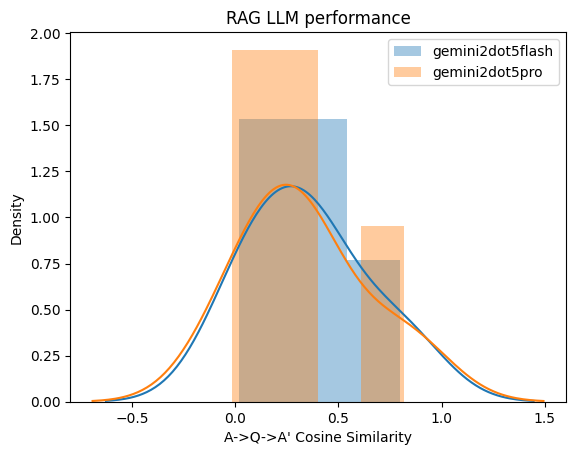

In [37]:
sns.distplot(df_gemini2dot5flash['cosine'], label='gemini2dot5flash')
sns.distplot(df_gemini2dot5pro['cosine'], label='gemini2dot5pro')

plt.title("RAG LLM performance")
plt.xlabel("A->Q->A' Cosine Similarity")
plt.legend()